<a href="https://colab.research.google.com/github/danisimoneaux/IS4487/blob/main/Lab14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IS 4487 Module 7 Script

## Objectives

What do you need to know for this module's project?

1.  Use the model to predict on a new dataset (without the target), then use these predictions to identify those who should be called--a contact list.
2.  Make a recommendation to the Director of Sales based on your analytic work.

**NOTE:** For the module 7 project you will predict answering for prospective customers (who have not yet been called). Consequently, the assignment requires an additional dataset, customer_data.csv, that you will need to download and move into your project folder.  Here is code to load that data into memory after you have it saved in your project folder (your working directory). This code is included in the template script.

We will again use the MegaTelCo data for this demonstration.

##Load Libraries

In this class we will be using 
- Pandas
- Scikitlearn
- Matplotlib


In [ ]:
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import xgboost as xgb

from sklearn.tree import DecisionTreeClassifier, export_graphviz # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics  #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import confusion_matrix

## Getting data into Pandas

In this case we will load data from the statsmodels.org library

See the Canvas assignments and lectures for a description of the Megatelco data

**Note:** you will need to enter a code supplied by Google in the next step. 


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

df = pd.read_csv (r'/content/gdrive/MyDrive/Colab Notebooks/megatelco.csv')


Mounted at /content/gdrive


In [ ]:
#look at the top rows
df.head(10) 

,college,income,overage,leftover,house,handset_price,over_15mins_calls_per_month,average_call_duration,reported_satisfaction,reported_usage_level,considering_change_of_plan,leave,id
0,one,23859,70,0,519105,154,5.0,8,low,low,yes,LEAVE,8183
1,zero,72466,67,16,271182,262,5.0,5,low,low,yes,LEAVE,12501
2,zero,30883,60,0,647281,211,3.0,8,low,low,yes,STAY,7425
3,one,44512,0,22,754958,232,0.0,5,low,low,no,LEAVE,13488
4,zero,70535,0,0,653421,310,0.0,14,low,low,yes,STAY,11389
5,zero,143987,0,56,896544,778,5.0,1,low,high,yes,STAY,14674
6,one,96668,79,24,259329,365,5.0,6,low,avg,yes,LEAVE,19100
7,one,50083,0,0,160335,266,5.0,10,low,high,yes,STAY,18170
8,one,104392,0,0,247836,778,1.0,8,high,low,no,LEAVE,3201
9,one,37852,0,74,264893,857,0.0,2,low,low,yes,LEAVE,12612


In [ ]:
#look at the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   college                      5000 non-null   object 
 1   income                       5000 non-null   int64  
 2   overage                      5000 non-null   int64  
 3   leftover                     5000 non-null   int64  
 4   house                        5000 non-null   int64  
 5   handset_price                5000 non-null   int64  
 6   over_15mins_calls_per_month  4997 non-null   float64
 7   average_call_duration        5000 non-null   int64  
 8   reported_satisfaction        5000 non-null   object 
 9   reported_usage_level         5000 non-null   object 
 10  considering_change_of_plan   5000 non-null   object 
 11  leave                        5000 non-null   object 
 12  id                           5000 non-null   int64  
dtypes: float64(1), int

In [ ]:
#describe the data before cleaning it
df.describe()

,income,overage,leftover,house,handset_price,over_15mins_calls_per_month,average_call_duration,id
count,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,4997.000000,5000.000000,5000.000000
mean,79912.948400,85.119200,24.243600,493656.326600,7.876236e+02,7.744647,5.958800,10036.639400
std,41703.042384,85.655622,26.847496,254287.193865,2.828291e+04,8.806070,4.390417,5813.620304
min,-28811.000000,0.000000,0.000000,-796132.000000,1.300000e+02,0.000000,1.000000,2.000000
25%,41592.500000,0.000000,0.000000,260586.500000,2.190000e+02,1.000000,2.000000,4950.500000
50%,75041.500000,59.000000,15.000000,451865.500000,3.220000e+02,4.000000,5.000000,10126.000000
75%,115475.000000,177.000000,42.000000,701608.750000,5.280000e+02,14.000000,9.000000,15085.250000
max,159938.000000,335.000000,89.000000,1000000.000000,2.000234e+06,29.000000,15.000000,20000.000000


## Clean up the data
Did you notice anything unusual about the "house" amounts? 

How about the handset price and income?

Clean up the data in a  new datafram named "df_clean"


In [ ]:
#delete rows with outlier data; put it in a new dataframe
df_clean = df[(df['house'] > 0) & (df['income'] > 0) & (df['handset_price'] < 1000)]

#delete any rows with missing values in the clean dataframe
df_clean = df_clean.dropna() 

df_clean.describe()

,income,overage,leftover,house,handset_price,over_15mins_calls_per_month,average_call_duration,id
count,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000,4994.000000
mean,79911.270525,85.114738,24.244694,493946.252903,387.616340,7.739287,5.957549,10032.925110
std,41683.689543,85.610045,26.844259,253599.007645,213.659555,8.802897,4.389439,5815.013219
min,20028.000000,0.000000,0.000000,150305.000000,130.000000,0.000000,1.000000,2.000000
25%,41591.500000,0.000000,0.000000,260741.500000,219.000000,1.000000,2.000000,4943.000000
50%,74962.500000,59.000000,15.000000,452087.500000,322.000000,4.000000,5.000000,10124.000000
75%,115497.000000,177.000000,42.000000,701612.250000,528.000000,14.000000,9.000000,15082.750000
max,159938.000000,335.000000,89.000000,1000000.000000,899.000000,29.000000,15.000000,20000.000000


# Standardize attributes

- Convert "college" to 0,1
- Convert reported_satisfaction to 1,2,3
- Convert reported_usage_level to 1,2,3
- Convert considering_change_of_plan to 0,1
- Convert leave to 0,1

I'm going to leave the "leave" variable in place, just in case I need the original value

In [ ]:
df_clean.loc[df_clean['college'] == 'one', 'college'] = "1" 
df_clean.loc[df_clean['college'] == 'zero', 'college'] = "0"
df_clean.loc[df_clean['reported_satisfaction'] == 'low', 'reported_satisfaction'] = "1"
df_clean.loc[df_clean['reported_satisfaction'] == 'avg', 'reported_satisfaction'] = "2"
df_clean.loc[df_clean['reported_satisfaction'] == 'high', 'reported_satisfaction'] = "3"
df_clean.loc[df_clean['reported_usage_level'] == 'low', 'reported_usage_level'] = "1"
df_clean.loc[df_clean['reported_usage_level'] == 'avg', 'reported_usage_level'] = "2"
df_clean.loc[df_clean['reported_usage_level'] == 'high', 'reported_usage_level'] = "3"
df_clean.loc[df_clean['considering_change_of_plan'] == 'yes', 'considering_change_of_plan'] = "1"
df_clean.loc[df_clean['considering_change_of_plan'] == 'no', 'considering_change_of_plan'] = "0"
df_clean.loc[df_clean['considering_change_of_plan'] == 'maybe', 'considering_change_of_plan'] = "0.5"

df_clean['college'] = df_clean['college'].astype('int') 
df_clean['reported_satisfaction'] = df_clean['reported_satisfaction'].astype('int') 
df_clean['reported_usage_level'] = df_clean['reported_usage_level'].astype('int') 
df_clean['considering_change_of_plan'] = df_clean['considering_change_of_plan'].astype('float') 

#Add new field with binary value for leave  
df_clean['leave_flag'] = df_clean['leave'].str.replace('STAY','0')  
df_clean['leave_flag'] = df_clean['leave_flag'].str.replace('LEAVE','1')
df_clean['leave_flag'] = df_clean['leave_flag'].astype('int')
df_clean['leave_flag'] = df_clean['leave_flag'].astype('bool')

df_clean.head(10) 

,college,income,overage,leftover,house,handset_price,over_15mins_calls_per_month,average_call_duration,reported_satisfaction,reported_usage_level,considering_change_of_plan,leave,id,leave_flag
0,1,23859,70,0,519105,154,5.0,8,1,1,1.0,LEAVE,8183,True
1,0,72466,67,16,271182,262,5.0,5,1,1,1.0,LEAVE,12501,True
2,0,30883,60,0,647281,211,3.0,8,1,1,1.0,STAY,7425,False
3,1,44512,0,22,754958,232,0.0,5,1,1,0.0,LEAVE,13488,True
4,0,70535,0,0,653421,310,0.0,14,1,1,1.0,STAY,11389,False
5,0,143987,0,56,896544,778,5.0,1,1,3,1.0,STAY,14674,False
6,1,96668,79,24,259329,365,5.0,6,1,2,1.0,LEAVE,19100,True
7,1,50083,0,0,160335,266,5.0,10,1,3,1.0,STAY,18170,False
8,1,104392,0,0,247836,778,1.0,8,3,1,0.0,LEAVE,3201,True
9,1,37852,0,74,264893,857,0.0,2,1,1,1.0,LEAVE,12612,True


# Convert attributes to factors

- Leave
- College
- Reported satisfaction
- Reported usage level
- Considering change of plan

In [ ]:
df_clean['leave'] = df_clean['leave'].astype('category')
df_clean['college'] = df_clean['college'].astype('category')
df_clean['reported_satisfaction'] = df_clean['reported_satisfaction'].astype('category')
df_clean['reported_usage_level'] = df_clean['reported_usage_level'].astype('category')
df_clean['considering_change_of_plan'] = df_clean['considering_change_of_plan'].astype('category')

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4994 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   college                      4994 non-null   category
 1   income                       4994 non-null   int64   
 2   overage                      4994 non-null   int64   
 3   leftover                     4994 non-null   int64   
 4   house                        4994 non-null   int64   
 5   handset_price                4994 non-null   int64   
 6   over_15mins_calls_per_month  4994 non-null   float64 
 7   average_call_duration        4994 non-null   int64   
 8   reported_satisfaction        4994 non-null   category
 9   reported_usage_level         4994 non-null   category
 10  considering_change_of_plan   4994 non-null   category
 11  leave                        4994 non-null   category
 12  id                           4994 non-null   int64   
 13  lea

# What is the base probability of leaving?

If we use no model at all, how good is our chance of predicting someone leaving?

In [ ]:
df_clean['leave_flag'].mean()

0.4941930316379656

## Split the dataset 

Split dataset into 80% training data and 20% test data


In [ ]:
# split the datafram into independent (x) and dependent (predicted) attributes (y)
x = df_clean[['income','house','college','overage','leftover','handset_price','over_15mins_calls_per_month','average_call_duration']] #,'reported_satisfaction','reported_usage_level','considering_change_of_plan']]
y = df_clean['leave_flag']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)  


## Fit a basic tree model and create a confusion matrix

Use all available attributes

In [ ]:
full_tree = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Create Decision Tree Classifer
full_tree = full_tree.fit(x_train,y_train)

# Use the tree to predict "leave"
y_predict = full_tree.predict(x_test)



## What is the accuracy on the test dataset?

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))

Accuracy: 0.7227227227227228


## View the confusion matrix



[[315 191]
 [ 86 407]]


[Text(0, 0.5, 'Stay'), Text(0, 1.5, 'Leave')]

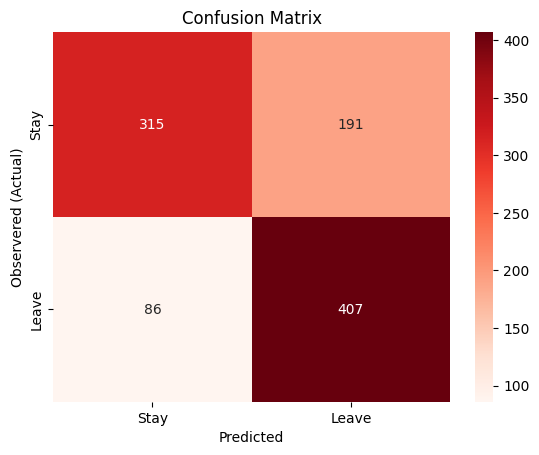

In [ ]:
# create a confusion matrix
full_tree_matrix = confusion_matrix(y_test, y_predict)
print(full_tree_matrix)

#Create a heatmap from our confusion matrix
cm = sns.heatmap(full_tree_matrix, annot=True, fmt='d',cmap='Reds')

cm.set_title('Confusion Matrix');
cm.set_xlabel('Predicted')
cm.set_ylabel('Observered (Actual)');

cm.xaxis.set_ticklabels(['Stay','Leave'])
cm.yaxis.set_ticklabels(['Stay','Leave'])

# Apply the model to a new dataset

In this dataset, we don't know answer.  We need to predict if they will stay or leave

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

#Import the new data
df_new = pd.read_csv (r'/content/gdrive/MyDrive/Colab Notebooks/megatelco.csv')


Mounted at /content/gdrive


In [ ]:
#Preview the new data
df_new.describe()

,income,overage,leftover,house,handset_price,over_15mins_calls_per_month,average_call_duration,id
count,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03,4997.000000,5000.000000,5000.000000
mean,79912.948400,85.119200,24.243600,493656.326600,7.876236e+02,7.744647,5.958800,10036.639400
std,41703.042384,85.655622,26.847496,254287.193865,2.828291e+04,8.806070,4.390417,5813.620304
min,-28811.000000,0.000000,0.000000,-796132.000000,1.300000e+02,0.000000,1.000000,2.000000
25%,41592.500000,0.000000,0.000000,260586.500000,2.190000e+02,1.000000,2.000000,4950.500000
50%,75041.500000,59.000000,15.000000,451865.500000,3.220000e+02,4.000000,5.000000,10126.000000
75%,115475.000000,177.000000,42.000000,701608.750000,5.280000e+02,14.000000,9.000000,15085.250000
max,159938.000000,335.000000,89.000000,1000000.000000,2.000234e+06,29.000000,15.000000,20000.000000


In [ ]:
#delete rows with outlier data; put it in a new dataframe
df_clean_new = df_new[(df_new['house'] > 0) & (df_new['income'] > 0) & (df_new['handset_price'] < 1000)]

#delete any rows with missing values in the clean dataframe
df_clean_new = df_clean_new.dropna() 

#standardize attributes
df_clean_new.loc[df_clean_new['college'] == 'one', 'college'] = "1" 
df_clean_new.loc[df_clean_new['college'] == 'zero', 'college'] = "0"
df_clean_new.loc[df_clean_new['reported_satisfaction'] == 'low', 'reported_satisfaction'] = "1"
df_clean_new.loc[df_clean_new['reported_satisfaction'] == 'avg', 'reported_satisfaction'] = "2"
df_clean_new.loc[df_clean_new['reported_satisfaction'] == 'high', 'reported_satisfaction'] = "3"
df_clean_new.loc[df_clean_new['reported_usage_level'] == 'low', 'reported_usage_level'] = "1"
df_clean_new.loc[df_clean_new['reported_usage_level'] == 'avg', 'reported_usage_level'] = "2"
df_clean_new.loc[df_clean_new['reported_usage_level'] == 'high', 'reported_usage_level'] = "3"
df_clean_new.loc[df_clean_new['considering_change_of_plan'] == 'yes', 'considering_change_of_plan'] = "1"
df_clean_new.loc[df_clean_new['considering_change_of_plan'] == 'no', 'considering_change_of_plan'] = "0"
df_clean_new.loc[df_clean_new['considering_change_of_plan'] == 'maybe', 'considering_change_of_plan'] = "0.5"

df_clean_new['college'] = df_clean_new['college'].astype('int') 
df_clean_new['reported_satisfaction'] = df_clean_new['reported_satisfaction'].astype('int') 
df_clean_new['reported_usage_level'] = df_clean_new['reported_usage_level'].astype('int') 
df_clean_new['considering_change_of_plan'] = df_clean_new['considering_change_of_plan'].astype('float') 

#There is no "leave" or "leave_flag"

df_clean_new.head(10) 




,college,income,overage,leftover,house,handset_price,over_15mins_calls_per_month,average_call_duration,reported_satisfaction,reported_usage_level,considering_change_of_plan,leave,id
0,1,23859,70,0,519105,154,5.0,8,1,1,1.0,LEAVE,8183
1,0,72466,67,16,271182,262,5.0,5,1,1,1.0,LEAVE,12501
2,0,30883,60,0,647281,211,3.0,8,1,1,1.0,STAY,7425
3,1,44512,0,22,754958,232,0.0,5,1,1,0.0,LEAVE,13488
4,0,70535,0,0,653421,310,0.0,14,1,1,1.0,STAY,11389
5,0,143987,0,56,896544,778,5.0,1,1,3,1.0,STAY,14674
6,1,96668,79,24,259329,365,5.0,6,1,2,1.0,LEAVE,19100
7,1,50083,0,0,160335,266,5.0,10,1,3,1.0,STAY,18170
8,1,104392,0,0,247836,778,1.0,8,3,1,0.0,LEAVE,3201
9,1,37852,0,74,264893,857,0.0,2,1,1,1.0,LEAVE,12612


In [ ]:
# split the datafram into independent (x) and dependent (predicted) attributes (y)
x_new = df_clean_new[['income','house','college','overage','leftover','handset_price','over_15mins_calls_per_month','average_call_duration']] #,'reported_satisfaction','reported_usage_level','considering_change_of_plan']]


## Predict the customers

Use the tree that we created earlier
Take the customers one by one and pass it to the model, or create a mailing by passing a batch

In [ ]:
# Use the tree to predict "leave" for the first customer
y_new_predict = full_tree.predict(x_new.iloc[:1])

#Convert it to a dataframe
df_new_predict = pd.DataFrame(y_new_predict)

df_new_predict.head()

,0
0,True


In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# load data
dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

FileNotFoundError: ignored

## How do we test the accuracy?
